# Tutorial proyecto de clasificación de texto mediante Hugging Face (2 clases)

## ¿Qué vamos a construir?

Bienvenido al tutorial del proyecto de clasificación de texto mediante Hugging Face. Este notebook está diseñado para que pueda ser reutilizable para otros casos.
En concreto, vamos a construir un modelo que, a partir de una frase en inglés, va a determinar si se trata de comida o no (`food` o `not_food`). Para hacerlo, vamos a partir de un modelo ya existente en Hugging Face Hub, y lo vamos a adaptar a nuestras necesidades. Estos son los pasos que vamos a seguir:
1. Datos: Definición del problema y adaptación de los datos
2. Modelo: Entrenamiento y evaluación de modelo adecuado para nuestro problema.
3. Demo: Vamos a crear una web pública donde cualquier persona podrá usar el modelo.

## ¿Qué ventajas tiene aplicar esta técnica?
Utilizar un modelo previamente entrenado y adaptarlo a nuestras necesidades específicas puede ser una estrategia muy beneficiosa. Existen muchos modelos disponibles, por ejemplo, en Hugging Face Hub, y podemos ajustarlos con una pequeña cantidad de datos para que cumplan con nuestras necesidades concretas.

Estos modelos suelen ser relativamente ligeros en términos de tamaño, pero mantienen un alto grado de precisión, lo que los hace muy útiles para una amplia variedad de aplicaciones. Al ajustar un modelo, podemos implementarlo de forma eficiente en nuestro equipo local o en un servidor, integrándolo como una parte fundamental de una aplicación más amplia. Esta flexibilidad permite optimizar recursos y reducir significativamente el tiempo de desarrollo.

## Obtención y tratamiento de los datos

### Importación de las librerías necesarias

In [4]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [5]:
# Install dependencies
try:
    import datasets, evaluate, accelerate, transformers
    import gradio as gr
except ModuleNotFoundError:
    !pip install -U datasets evaluate accelerate gradio transformers
    import datasets, evaluate, accelerate
    import gradio as gr

import random
import numpy as np
import pandas as pd

import torch
import transformers

print(f"Using transformers version: {transformers.__version__}")
print(f"Using torch version: {torch.__version__}")
print(f"Using datasets version: {datasets.__version__}")

/home/acm/Coding/ztm_courses/ztm-huggingface/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using transformers version: 4.45.2
Using torch version: 2.4.1+cu121
Using datasets version: 3.0.1


### Obtención de un dataset

In [6]:
from datasets import load_dataset

dataset = load_dataset(path='mrdbourke/learn_hf_food_not_food_image_captions')

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

In [8]:
# Cómo son los datos?
dataset.column_names

{'train': ['text', 'label']}

In [9]:
# Accedemos al set de entrenamiento
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 250
})

In [10]:
dataset['train'][0]

{'text': 'Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
 'label': 'food'}

### Inspeccionamos ejemplos random

In [11]:
import random

random_indexs = random.sample(range(len(dataset['train'])), 5)
random_indexs

random_samples = dataset['train'][random_indexs]
print(f"[INFO] Random samples from dataset:\n")
for text, label in zip(random_samples['text'], random_samples['label']):
    print(f"Text: {text} | Label: {label}")

[INFO] Random samples from dataset:

Text: Jicama in a bowl, sprinkled with chili powder and served with a side of lime wedges for a refreshing snack. | Label: food
Text: Set of tea towels folded in a kitchen | Label: not_food
Text: Creamy spinach and potato curry, featuring fluffy potatoes and nutritious spinach in a rich sauce with cream and garam masala. | Label: food
Text: Set of candles lit on a table | Label: not_food
Text: Flat screen TV neatly mounted on a wall | Label: not_food


In [12]:
# Obtenemos los valores únicos de las etiquetas
dataset['train'].unique('label')

['food', 'not_food']

In [13]:
# Contamos la cantidad de frases para cada etiqueta
from collections import Counter

Counter(dataset['train']['label'])

Counter({'food': 125, 'not_food': 125})

In [14]:
# Convertimos el dataset en un pandas DataFrame y tomamos una muestra
food_not_food_df = pd.DataFrame(dataset['train'])
food_not_food_df.sample(7)

,text,label
55,"Uniquely shaped sushi roll, such as a heart or...",food
120,A slice of pepperoni pizza with a layer of mel...,food
199,"Crunchy sushi roll with a creamy filling, feat...",food
140,"A gourmet pizza with a pesto base, topped with...",food
161,Set of measuring cups nested in a drawer,not_food
141,A slice of pizza with a spicy buffalo chicken ...,food
216,"Pizza with a unique crust, such as cauliflower...",food


In [15]:
food_not_food_df['label'].value_counts()

label
food        125
not_food    125
Name: count, dtype: int64

### Preparación de los datos para la clasificación de texto

Queremos:
1. Tokenizar nuestro texto - convertir texto en números (esto aplica para las frases y las etiquetas)
2. Crear un train/test split - queremos entrentar nuestro modelo en el training split y evaluarlo en el test split

In [16]:
# Crear un mapeo para labels hacia un número id
id2label ={0: "not_food", 1: "food"}
label2id = {"not_food": 0, "food":1}

print(id2label)
print(label2id)

{0: 'not_food', 1: 'food'}
{'not_food': 0, 'food': 1}


In [17]:
# Creando mappings para labels hacia números id de forma automática (especialmente útil cuando se trata de más de 2 clases)
id2label = {idx: label for idx, label in enumerate(dataset['train'].unique('label')[::-1])}
print(id2label)

{0: 'not_food', 1: 'food'}


In [18]:
label2id = {label: idx for idx,label in id2label.items()}
print(label2id)

{'not_food': 0, 'food': 1}


In [19]:
# Convierte labels en 0 y 1
def map_labels_to_number(example):
    example['label'] = label2id[example['label']]
    return example

example_sample = {'text': 'This is a sentence about my favourite food: honey', 'label': 'food'}
map_labels_to_number(example_sample)

{'text': 'This is a sentence about my favourite food: honey', 'label': 1}

In [20]:
# Mapea las labels del dataset entero a números  
dataset = dataset['train'].map(map_labels_to_number)
dataset[:5]

{'text': ['Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
  'Set of books stacked on a desk',
  'Watching TV together, a family has their dog stretched out on the floor',
  'Wooden dresser with a mirror reflecting the room',
  'Lawn mower stored in a shed'],
 'label': [1, 0, 0, 0, 0]}

In [21]:
# Mezclar datos y observar más muestras aleatorias
dataset.shuffle()[:5]

{'text': ['Set of paintbrushes stored in a jar',
  'A close-up of a girl feeding her rabbit in the garden',
  'A boy giving his dog a bath in the backyard',
  'Set of baking sheets stacked in a cabinet',
  'Camping tent pitched in a backyard'],
 'label': [0, 0, 0, 0, 0]}

In [22]:
### Dividir el dataset en training y test sets
dataset = dataset.train_test_split(test_size=0.2, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

In [23]:
random_idx_train = random.randint(0, len(dataset['train']))
random_sample_train = dataset['train'][random_idx_train]
random_sample_train

{'text': 'A pair of slices from a barbecue chicken pizza', 'label': 1}

In [24]:
random_idx_test = random.randint(0, len(dataset['test']))
random_sample_test = dataset['test'][random_idx_test]
random_sample_test

{'text': 'Comforting lamb curry bowl, featuring tender lamb slow-cooked in a flavorful sauce with cumin and coriander, garnished with toasted cumin seeds.',
 'label': 1}

### Tokenizar el texto

Consiste básicamente en transformar texto a números. Es importante tomar el mismo `tokenizer` con el que los datos fueron entrenados. En nuestro caso, vamos a usar el tokenizer del modelo `distilbert/distilbert-base-uncased`

In [25]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path='distilbert/distilbert-base-uncased',
                                         use_fast=True) # Use the fast implementation (on by default)
tokenizer


DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [26]:
# Probamos el tokenizer
tokenizer("I love pizza")

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

* `input_ids` = texto convertido en números
* `attention_mask` = indica si hay que prestarle atención al input o no (1=sí prestar atención, 0 = no, no prestar atención)

In [27]:
tokenizer('I love pizza!')

{'input_ids': [101, 1045, 2293, 10733, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [29]:
# Calculamos cuán largo es el vocabulario del tokenizer escogido
length_of_tokenizer_vocab = len(tokenizer.vocab)
print(f"[INFO] Tamaño del vocabulario del tokenizer: {length_of_tokenizer_vocab} tokens")

# Obtenemos la longitud máxima de secuencia que el tokenizer puede manejar
max_tokenizer_input_sequence_length = tokenizer.model_max_length
print(f"[INFO] Longitud máxima de entrada que puede procesar el tokenizer: {max_tokenizer_input_sequence_length} tokens")

[INFO] Tamaño del vocabulario del tokenizer: 30522 tokens
[INFO] Longitud máxima de entrada que puede procesar el tokenizer: 512 tokens


In [31]:
# Está "antonio" en el vocabulario? Vemos que sí
tokenizer.vocab['antonio']

4980

In [32]:
# Está "akash" en el vocabularoi? Vemos que no, da error
tokenizer.vocab['akash']

KeyError: 'akash'

In [33]:
tokenizer('akash')

{'input_ids': [101, 9875, 4095, 102], 'attention_mask': [1, 1, 1, 1]}

Las palabras que no están en el vocabulario del tokenizer igual son procesadas por este. Tal como se puede ver con "akash", el tokenizer ha subdividido la palabra en 2.

In [29]:
tokenizer.convert_ids_to_tokens(tokenizer('akash').input_ids)

['[CLS]', 'aka', '##sh', '[SEP]']

In [34]:
# Intentamos tokenizar un emoji
tokenizer.convert_ids_to_tokens(tokenizer("😆").input_ids)

['[CLS]', '[UNK]', '[SEP]']

In [35]:
# Tomamos los 5 primeros items del vocabulario
sorted(tokenizer.vocab.items())[:5]

[('!', 999), ('"', 1000), ('#', 1001), ('##!', 29612), ('##"', 29613)]

In [32]:
import random
random.sample(sorted(tokenizer.vocab.items()), k=5)

[('guarantees', 21586),
 ('drummond', 19266),
 ('##watch', 18866),
 ('regretted', 18991),
 ('what', 2054)]

### Creamos una función para tokenizar texto

In [37]:
def tokenize_text(ejemplos):
    """
    Tokeniza el texto del ejemplo dado y devuelve el texto tokenizado.
    """
    return tokenizer(ejemplos['text'],
                    padding=True,  # rellena las secuencias cortas al tamaño de la secuencia más larga en el lote
                    truncation=True)  # trunca las secuencias largas a la longitud máxima que el modelo puede procesar.

In [38]:
example_sample_2 = {"text": "I love pizza", "label": 1}

# Probamos la función
tokenize_text(example_sample_2)

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [39]:
long_text = "I love pizza " * 1000
long_text
len(long_text)

13000

In [40]:
tokenized_long_text = tokenize_text({"text": long_text, "label": 1})
len(tokenized_long_text['input_ids'])

512

In [41]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

In [42]:
# Mapeamos la función tokenizer a todo el dataset
tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True, # set batched=True to tokenize across batches of samples at a time
                                batch_size=1000)

Map: 100%|█████████████████████████████| 50/50 [00:00<00:00, 9143.49 examples/s]


In [43]:
# Tomamos 2 ejemplos
train_tokenized_sample = tokenized_dataset['train'][0]
test_tokenized_sample = tokenized_dataset['test'][0]

for key in train_tokenized_sample.keys():
    print(f"[INFO] Key: {key}")
    print(f"Train sample: {train_tokenized_sample[key]}")
    print(f"Test sample: {test_tokenized_sample[key]}")
    print()

[INFO] Key: text
Train sample: Set of headphones placed on a desk
Test sample: A slice of pepperoni pizza with a layer of melted cheese

[INFO] Key: label
Train sample: 0
Test sample: 1

[INFO] Key: input_ids
Train sample: [101, 2275, 1997, 2132, 19093, 2872, 2006, 1037, 4624, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [101, 1037, 14704, 1997, 11565, 10698, 10733, 2007, 1037, 6741, 1997, 12501, 8808, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[INFO] Key: attention_mask
Train sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



### Puntos claves sobre la tokenización
1. Tokenizers = Convertir datos en números
2. Hay muchos modelos disponibles con diferentes tokenizers; las herramientas `Auto` de Hugging Face (por ejemplo, `AutoTokenizer`, `AutoProcessor`, `AutoModel`, etc.) ayudan a emparejar tokenizers con los modelos correctos.
3. Tokenización se puede hacer en paralelo usando funciones como `map` y en lotes (`batched`)

## Preparación del modelo

Antes de configurar el modelo, debemos definir también cómo se medirá cuán buenas han sido las predicciones del modelo.

### Seteando una métrica de evaluación

Queremos escoger una métrica de evaluación que nos permita tener una idea númerica de cuán bien nuestro modelo está funcionando.

Algunas métricas de evaluación comunes son:
- 

Some common evaluation metrics for classification:
- Exactitud (Accuracy) (Cuántos ejemplos de cada 100 se clasificaron bien?)
- Precisión (Precision)
- Sensibilidad o Exhaustividad (Recall)
- F1 Score

La métrica de evaluación es importante porque en algunos proyectos puede haber algún mínimo que cumplir

Algun formas para encontrar métricas de evaluación:
- Scikit evaluation
- Hugging Face evaluate

In [45]:
!pip install scikit-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [58]:
import evaluate
import numpy as np
from typing import Tuple

accuracy_metric = evaluate.load('accuracy')

def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
    """
    Computes the accuracy of a model by comparing the predictions and labels.
    """
    predictions, labels = predictions_and_labels

    if len(predictions.shape) >= 2:
        # need to get the maximum value from the model output (the index) as this is the "most likely" label according to the model
        predictions = np.argmax(predictions, axis=1)

    return accuracy_metric.compute(predictions=predictions, references=labels)

In [48]:
# Ejemplo de predicciones y de la métrica de exactitud
example_preds_all_correct = np.array([0,0,0,0,0,0,0,0,0,0])
example_preds_one_incorrect = np.array([0,0,0,0,1,0,0,0,0,0])
example_labels = np.array([0,0,0,0,0,0,0,0,0,0])

# Test the function
print(f"Accuracy when all predictions are correct: {compute_accuracy((example_preds_all_correct, example_labels))}")
print(f"Accuracy when all one prediction is correct: {compute_accuracy((example_preds_one_incorrect, example_labels))}")

Accuracy when all predictions are correct: {'accuracy': 1.0}
Accuracy when all one prediction is correct: {'accuracy': 0.9}


### Seteamos un modelo para el entrenamiento

Flujo de trabajo:
1. Crear y preprocesar los datos (hecho)
2. Definir el modelo que nos gustaría usar para nuestro problema (huggingface/models) o consultar las "guías de tareas" en la documentación de HF Transformers
3. Definir los argumentos de entrenamiento para entrenar nuestro modelo `transformers.TrainingArguments`
4. Pasar los `TrainingArguments` a una instancia de `transformer.Trainer`
5. Entrenar el modelo llamando a `Trainer.train()`
6. Guardar nuestro modelo (en nuestra máquina local o en el Hugging Face Hub)
7. Evaluar el modelo entrenado realizando y examinando predicciones sobre los datos de prueba
8. Convertir el modelo en una demostración compartible

In [49]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path = 'distilbert/distilbert-base-uncased',
    num_labels=2, # Classify into food, not food
    id2label=id2label,
    label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

Nuestro modelo se compone de las siguientes partes:
1. `embeddings` - los embeddings son una forma de representación aprendida de los tokens. Así que, si los tokens son un mapeo directo de token a número, los embeddings son una representación vectorial aprendida.
2. `transformer` - la columna vertebral de nuestra arquitectura de modelo, que ha descubierto patrones/relaciones en los embeddings.
3. `classifier` - necesitamos personalizar esta capa para adaptarla a nuestro problema.

In [51]:
tokenized_dataset['train'][0]

{'text': 'Set of headphones placed on a desk',
 'label': 0,
 'input_ids': [101,
  2275,
  1997,
  2132,
  19093,
  2872,
  2006,
  1037,
  4624,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

Nota: Si obtienes errores de entrada al pasar una muestra a un modelo, asegúrate de que la muestra que le pasas al modelo esté en el mismo formato en el que fue entrenado. Por ejemplo, si tu modelo usó un tokenizer específico, asegúrate de tokenizar tu texto antes de pasarlo al modelo.

In [52]:
model(input_ids=tokenized_dataset['train'][0]['input_ids'],
     attention_mask=tokenized_dataset['train'][0]['attention_mask'])

AttributeError: 'list' object has no attribute 'size'

### Contando los parámetros en nuestro modelo

Pesos/parámetros = pequeñas oportunidades numéricas para que un modelo aprenda patrones en los datos.

In [53]:
def count_params(model):
    """
    Count the parameters of a PyTorch model.
    """
    trainable_parameters = sum(param.numel() for param in model.parameters() if param.requires_grad)
    total_parameters = sum(param.numel() for param in model.parameters())

    return {"trainable_parameters": trainable_parameters, "total_parameters": total_parameters}

count_params(model)

{'trainable_parameters': 66955010, 'total_parameters': 66955010}

Parece que nuestro modelo tiene alrededor de 67 millones de parámetros y todos son entrenables

Nota:

* En general, cuantos más parámetros tenga un modelo, mayor capacidad tendrá para aprender.
* Para ponerlo en perspectiva, modelos como Llama3 8B tienen 8 mil millones de parámetros.
* Si buscas el mejor rendimiento posible, generalmente más parámetros es mejor.
* Sin embargo, con más parámetros se requiere más capacidad de cómputo y tiempo.
* Te sorprenderá lo bien que puede funcionar un modelo más pequeño con datos específicos.

In [48]:
8_000_000_000/67_000_000

119.40298507462687

### Creando un directorio para guardar los modelos

In [54]:
# Creamos un directorio para guardar los modelos
from pathlib import Path

# Create models dir
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

# Create model save name
model_save_name = "learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

# Create model save path
model_save_dir = Path(models_dir, model_save_name)

model_save_dir

PosixPath('models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased')

### Configuración de los argumentos de entrenamiento (hiperparámetros) con TrainingArguments

In [56]:
from transformers import TrainingArguments

print(f"[INFO] Guardando checkpoints del modelo: {model_save_dir}")

BATCH_SIZE = 32

# Create training arguments 
training_args = TrainingArguments(
    output_dir=model_save_dir,
    learning_rate=0.0001,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    use_cpu=False,
    seed=42,
    load_best_model_at_end=True,
    logging_strategy="epoch",
    report_to="none",
    # push_to_hub=True
    hub_private_repo=False #When uploading to Hugging Face, do you want your model to be private or public (default public)
    
)

[INFO] Guardando checkpoints del modelo: models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased


In [57]:
training_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False,
evaluation_s

### Seteando una instancia de Trainer

In [59]:
from transformers import Trainer

# Setup Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy
)

trainer

### ¡Entrenamos el modelo!

In [60]:
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.399200,0.107463,0.980000
2,0.044100,0.059367,0.980000
3,0.005900,0.002254,1.000000
4,0.001900,0.001139,1.000000
5,0.001200,0.000792,1.000000
6,0.000900,0.000636,1.000000
7,0.000700,0.000553,1.000000
8,0.000700,0.000506,1.000000
9,0.000600,0.000481,1.000000
10,0.000600,0.000473,1.000000


In [61]:
# Inspeccionamos las métricas del modelo
for key, value in results.metrics.items():
    print(f"{key}: {value}")

train_runtime: 16.3294
train_samples_per_second: 122.479
train_steps_per_second: 4.287
total_flos: 18110777160000.0
train_loss: 0.04557784213019269
epoch: 10.0


### Guardamos el modelo para poder usarlo posteriormente

**Nota**: Si estás guardando el modelo en Google Colab, ten en cuenta que desaparecerá de tu instancia de Colab cuando se desconecte.

In [62]:
# Save model
print(f"[INFO] Saving model to {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)

[INFO] Saving model to models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased


## Inspeccionamos las métricas del entrenamiento

In [64]:
# Obtenemos la historia del entrenamiento
trainer_history_all = trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1]
trainer_history_training_time = trainer_history_all[-1]

# Vemos las primeras 3
trainer_history_metrics[:3]

[{'loss': 0.3992,
  'grad_norm': 1.7019474506378174,
  'learning_rate': 9e-05,
  'epoch': 1.0,
  'step': 7},
 {'eval_loss': 0.10746302455663681,
  'eval_accuracy': 0.98,
  'eval_runtime': 0.0429,
  'eval_samples_per_second': 1164.657,
  'eval_steps_per_second': 46.586,
  'epoch': 1.0,
  'step': 7},
 {'loss': 0.0441,
  'grad_norm': 0.14603981375694275,
  'learning_rate': 8e-05,
  'epoch': 2.0,
  'step': 14}]

In [65]:
import pprint

# Extraemos las métricas eval y training
trainer_history_training_set = []
trainer_history_eval_set = []

# Loop a través de las métricas
for item in trainer_history_metrics:
    item_keys = list(item.keys())
    if any("eval" in item for item in item_keys):
        trainer_history_eval_set.append(item)
    else:
        trainer_history_training_set.append(item)

# Mostramos los 2 primeros de cada uno
print(f"Primeros 2 en training set:")
pprint.pprint(trainer_history_training_set[:2])

print(f"\nPrimeros 2 en eval epochs:")
pprint.pprint(trainer_history_eval_set[:2])

Primeros 2 en training set:
[{'epoch': 1.0,
  'grad_norm': 1.7019474506378174,
  'learning_rate': 9e-05,
  'loss': 0.3992,
  'step': 7},
 {'epoch': 2.0,
  'grad_norm': 0.14603981375694275,
  'learning_rate': 8e-05,
  'loss': 0.0441,
  'step': 14}]

Primeros 2 en eval epochs:
[{'epoch': 1.0,
  'eval_accuracy': 0.98,
  'eval_loss': 0.10746302455663681,
  'eval_runtime': 0.0429,
  'eval_samples_per_second': 1164.657,
  'eval_steps_per_second': 46.586,
  'step': 7},
 {'epoch': 2.0,
  'eval_accuracy': 0.98,
  'eval_loss': 0.059366654604673386,
  'eval_runtime': 0.0421,
  'eval_samples_per_second': 1186.4,
  'eval_steps_per_second': 47.456,
  'step': 14}]


### Revisando las `loss curves`

In [66]:
# Crear un pandas DataFrame para training y evaluation metrics
trainer_history_train_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

trainer_history_train_df.head()

,loss,grad_norm,learning_rate,epoch,step
0,0.3992,1.701947,0.00009,1.0,7
1,0.0441,0.146040,0.00008,2.0,14
2,0.0059,0.046152,0.00007,3.0,21
3,0.0019,0.022477,0.00006,4.0,28
4,0.0012,0.019875,0.00005,5.0,35


In [60]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


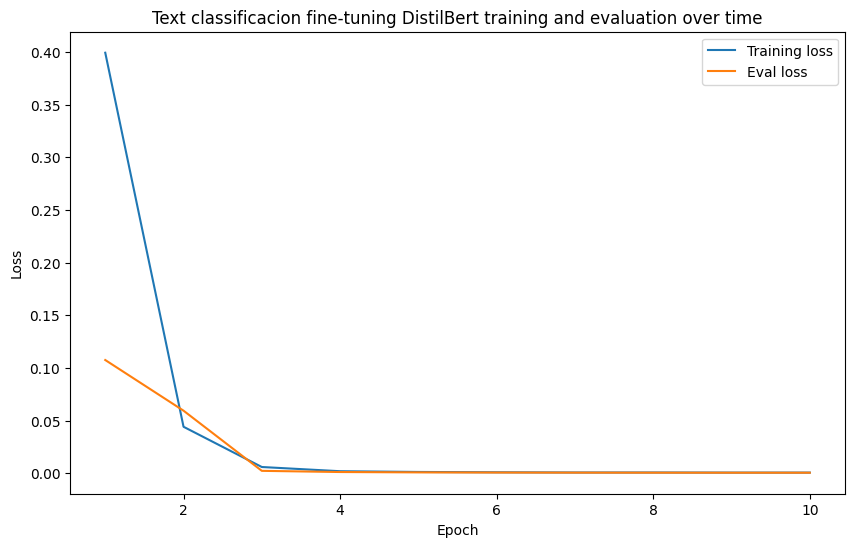

In [67]:
# plot the loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(trainer_history_train_df['epoch'], trainer_history_train_df['loss'], label="Training loss")
plt.plot(trainer_history_eval_df['epoch'], trainer_history_eval_df['eval_loss'], label="Eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Text classificacion fine-tuning DistilBert training and evaluation over time")
plt.legend()
plt.show()


### Subiendo nuestro modelo al Hugging Face Hub

¿Por qué hacer esto?
- Para poder compartir nuestro modelo.
- Otras personas pueden probarlo.
- Podemos mantener un historial de diferentes versiones del modelo.

Para escribir en Hugging Face:
- Si estás en Google Token: configura el "token" con acceso de "lectura y escritura".
- Si estás en una máquina local: configura `huggingface-cli`.

Para guardar en el Hugging Face Hub, podemos usar el método `Trainer.push_to_hub`.

In [68]:
from huggingface_hub import login
login(os.getenv("HF_TOKEN"))

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/acm/.cache/huggingface/token
Login successful


In [72]:
# Save our model to the Hugging Face Hub
model_upload_url = trainer.push_to_hub(
    commit_message="Subiendo el modelo de clasificador de texto de food/not_food",
)
print(f"[INFO] Model successfully uploaded to the Hugging Face Hub with URL: {model_upload_url}")

No files have been modified since last commit. Skipping to prevent empty commit.


[INFO] Model successfully uploaded to the Hugging Face Hub with URL: https://huggingface.co/tonicanada/learn_hf_food_not_food_text_classifier-distilbert-base-uncased/tree/main/


## Haciendo y evaluando predicciones en los datos test

**Nota**: Evaluar un modelo es tan importante como entrenarlo.

In [73]:
# Predicciones en el set de test
predictions_all = trainer.predict(tokenized_dataset['test'])
prediction_values = predictions_all.predictions
prediction_metrics = predictions_all.metrics

print(f"[INFO] Métricas de predicción en la data test:")
prediction_metrics

[INFO] Métricas de predicción en la data test:


{'test_loss': 0.0004733024397864938,
 'test_accuracy': 1.0,
 'test_runtime': 0.0736,
 'test_samples_per_second': 679.015,
 'test_steps_per_second': 27.161}

In [74]:
predictions_all

PredictionOutput(predictions=array([[-3.5655854,  4.050842 ],
       [ 4.108436 , -3.5667434],
       [-3.5987396,  4.051071 ],
       [ 4.189356 , -3.5941718],
       [ 4.174309 , -3.5734787],
       [-3.5950534,  4.062822 ],
       [ 4.179851 , -3.5814786],
       [ 4.1800413, -3.5784364],
       [-3.5961647,  4.0515275],
       [-3.5851297,  4.040712 ],
       [-3.5919209,  4.052533 ],
       [-3.5278883,  3.977925 ],
       [ 4.1621585, -3.5740569],
       [-3.5964828,  4.047571 ],
       [-3.575441 ,  4.0346985],
       [ 4.193889 , -3.570478 ],
       [-3.5895047,  4.049947 ],
       [ 4.134468 , -3.565461 ],
       [-3.6007972,  4.027627 ],
       [-3.6008315,  4.056313 ],
       [-3.5901027,  4.021924 ],
       [-3.5940216,  4.0449224],
       [ 4.157044 , -3.5858703],
       [ 4.184146 , -3.5836735],
       [-3.6022315,  4.0555916],
       [-3.601858 ,  4.031769 ],
       [-3.5864644,  4.0300655],
       [ 4.173559 , -3.5732865],
       [-3.5922463,  4.056378 ],
       [ 4.171

### Obtengamos las probabilidades predichas y evaluemos manualmente

In [75]:
# El modelo devuelve logits sin procesar
predictions_all.predictions[0]

array([-3.5655854,  4.050842 ], dtype=float32)

In [76]:
# Softmax convierte todos los valores para que estén entre 0 y 1 y la suma total de los valores sea 1
# Esto es lo que se conoce como "probabilidad de predicción"
torch.softmax(torch.tensor(predictions_all.predictions[0]), dim=0)

tensor([4.9206e-04, 9.9951e-01])

**Nota**: Si deseas un buen método de evaluación, haz predicciones sobre todo tu conjunto de datos de prueba, luego indexa las predicciones que son incorrectas pero tienen una alta probabilidad de predicción. Por ejemplo, obtén las 100-1000 principales y revisa todos los ejemplos donde la predicción del modelo tenía una alta probabilidad pero fue incorrecta -> esto a menudo conduce a excelentes percepciones sobre tus datos.

**Nota**: Estos valores no sugieren cuán "correcto" está el modelo, porque un modelo puede tener una alta probabilidad de predicción pero aún así estar equivocado.

In [77]:
# Predicted logits (raw outputs of the model) -> prediction probabilities with torch.softmax -> predicted labels
import torch
from sklearn.metrics import accuracy_score

# 1. Obtener prediction probabilities con torch.softmax
pred_probs = torch.softmax(torch.tensor(prediction_values), dim=1)
pred_probs

# 2. Obtener las predicted labels
pred_labels = torch.argmax(pred_probs, dim=1)
pred_labels

# 3. Obtener las true labels
true_labels = tokenized_dataset['test']['label']

# 4. Calcular las etiquetas de predicción con las etiquetas reales y obtener la precisión en el test
test_accuracy = accuracy_score(y_true = true_labels,
                               y_pred = pred_labels)

print(f"[INFO] Test accuracy: {test_accuracy*100}")

[INFO] Test accuracy: 100.0


### Explorando las probabilidades de predicción de nuestro modelo

Es una excelente manera de evaluar un modelo ordenando las predicciones y observando dónde se equivocó el modelo.

In [78]:
# Make a DataFrame of test predictions
test_predictions_df = pd.DataFrame({
    "text": dataset['test']['text'],
    "true_label": true_labels,
    "pred_label": pred_labels,
    "pred_probs": torch.max(pred_probs, dim=1).values
})

test_predictions_df.head()

,text,true_label,pred_label,pred_probs
0,A slice of pepperoni pizza with a layer of mel...,1,1,0.999508
1,Red brick fireplace with a mantel serving as a...,0,0,0.999536
2,A bowl of sliced bell peppers with a sprinkle ...,1,1,0.999524
3,Set of mugs hanging on a hook,0,0,0.999584
4,Standing floor lamp providing light next to an...,0,0,0.999569


In [79]:
# Muestra 10 ejemplos con baja prediction probability
test_predictions_df.sort_values("pred_probs", ascending=True).head(10)

,text,true_label,pred_label,pred_probs
40,A bowl of cherries with a sprig of mint for ga...,1,1,0.999209
11,A close-up shot of a cheesy pizza slice being ...,1,1,0.999450
49,Plate of sushi served with pickled ginger and ...,1,1,0.999504
14,Two handfuls of bananas in a fruit bowl with g...,1,1,0.999505
31,Crunchy sushi roll with tempura flakes or pank...,1,1,0.999505
20,"Pizza with a seafood theme, featuring toppings...",1,1,0.999506
37,"Close-up of a sushi roll with avocado, cucumbe...",1,1,0.999506
0,A slice of pepperoni pizza with a layer of mel...,1,1,0.999508
26,A fruit platter with a variety of exotic fruit...,1,1,0.999508
46,A bowl of sliced kiwi with a sprinkle of sugar...,1,1,0.999509


## Haciendo y evaluando predicciones en datos personalizados

Vamos a probar el modelo para que haga predicciones sobre frases que no están ni en el training set ni en el test set.

In [80]:
local_model_path = "models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

hugging_face_model_path = "tonicanada/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

### Discutiendo formas de hacer predicciones (inferencia)
* Nota: Siempre que escuches la palabra "inferencia", significa usar un modelo para hacer predicciones sobre datos.

Dos formas principales de realizar inferencia:
1. **Modo Pipeline** - Usando `transformers.pipeline` para cargar nuestro modelo y realizar clasificación de texto.
2. **Modo PyTorch** - Usando una combinación de `transformers.AutoTokenizer` y `transformers.AutoModelForSequenceClassification` y pasando el nombre de nuestro modelo objetivo.

Cada modo soporta:
1. Predicciones una a la vez (rápido, pero puede ser más lento con muchos, muchos ejemplos).
    * Útil para, por ejemplo, un sistema de comentarios donde los comentarios ocurren de forma esporádica, para predecir si el comentario es "spam" o "no spam".
2. Lotes de predicciones a la vez (más rápido, pero hasta cierto punto, por ejemplo, si predices 32 ejemplos a la vez, esto puede ser mucho más rápido que uno a la vez, pero si predices 128 a la vez, puede que no veas muchas más mejoras en la velocidad).
    * Útil cuando tienes una base de datos estática grande o muchos ejemplos entrando al mismo tiempo.


In [81]:
# Definiendo el device para hacer las predicciones
# Note: Normalmente si el hardware es más rápido, más rápidas son las predicciones, 
# por ejemplo, si tienes una GPU, te conviene usarla en lugar de la CPU 

def set_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

DEVICE = set_device()
print(f"[INFO] Using device: {DEVICE}")

[INFO] Using device: cuda


### Haciendo prediciones con el pipeline mode

In [82]:
!nvidia-smi

Wed Nov 13 23:24:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2070 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8               4W /  80W |   1598MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [83]:
import torch
from transformers import pipeline

# Set the batch size
BATCH_SIZE = 32 # reminder: prediction speed often increases with higher batch size (e.g. 1->32 but can saturate at even point)

# Create an instance of transformers.pipeline
food_not_food_classifier = pipeline(task="text-classification",
                                    model=local_model_path,
                                    device=DEVICE,
                                    top_k=1,
                                    batch_size=BATCH_SIZE)

food_not_food_classifier

In [84]:
test_custom_sentence = "A plate of pizza" 
food_not_food_classifier(test_custom_sentence)

[[{'label': 'food', 'score': 0.9984574317932129}]]

In [85]:
del pipeline
del food_not_food_classifier

In [86]:
# Use pipeline with a model from Hugging Face
from transformers import pipeline
food_not_food_classifier = pipeline(task="text-classification",
                                    model=hugging_face_model_path,
                                    device=DEVICE,
                                    top_k=1,
                                    batch_size=BATCH_SIZE)


In [87]:
food_not_food_classifier(test_custom_sentence)

[[{'label': 'food', 'score': 0.9984574317932129}]]

#### Hacer múltiples predicciones al mismo tiempo con predicción por lotes

In [88]:
# Crear una lista de oraciones para hacer predicciones
sentences = [
    "I whipped up a fresh batch of code, but it seems to have a syntax error.",
    "We need to marinate these ideas overnight before presenting them to the client.",
    "The new software is definitely a spicy upgrade, taking some time to get used to.",
    "Her social media post was the perfect recipe for a viral sensation.",
    "He served up a rebuttal full of facts, leaving his opponent speechless.",
    "The team needs to simmer down a bit before tackling the next challenge.",
    "The presentation was a delicious blend of humor and information, keeping the audience engaged.",
    "A beautiful array of fake wax foods (shokuhin sampuru) in the front of a Japanese restaurant.",
    "Daniel Bourke is really cool :D",
    "My favoruite food is biltong!"
]

food_not_food_classifier(sentences)

[[{'label': 'not_food', 'score': 0.9983304142951965}],
 [{'label': 'not_food', 'score': 0.9984914064407349}],
 [{'label': 'not_food', 'score': 0.9984080195426941}],
 [{'label': 'not_food', 'score': 0.9960306286811829}],
 [{'label': 'not_food', 'score': 0.9941054582595825}],
 [{'label': 'not_food', 'score': 0.9981845021247864}],
 [{'label': 'not_food', 'score': 0.9975733160972595}],
 [{'label': 'food', 'score': 0.9968075752258301}],
 [{'label': 'not_food', 'score': 0.9991003274917603}],
 [{'label': 'not_food', 'score': 0.9979191422462463}]]

#### Medir el tiempo de nuestro modelo con tamaños de muestra más grandes

In [89]:
import time

# Create 1000 sentences
sentences_1000 = sentences * 100

# Time how long it takes to make predictions on all sentences (one at a time)
print(f"[INFO] Cantidad de frases: {len(sentences_1000)}")
start_time_one_at_a_time = time.time()
for sentence in sentences_1000:
    # Realizar una predicción
    food_not_food_classifier(sentence)
end_time_one_at_a_time = time.time()

total_time_one_at_a_time = end_time_one_at_a_time - start_time_one_at_a_time
avg_time_per_pred = total_time_one_at_a_time/len(sentences_1000)
print(f"[INFO] Tiempo total para realizar predicciones en {len(sentences_1000)} frases (una por una): {total_time_one_at_a_time}s")
print(f"[INFO] Tiempo promedio para realizar una predicción (método una a una): {avg_time_per_pred}")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[INFO] Cantidad de frases: 1000
[INFO] Tiempo total para realizar predicciones en 1000 frases (una por una): 3.910560131072998s
[INFO] Tiempo promedio para realizar una predicción (método una a una): 0.003910560131072998


In [90]:
# Let's now use pipeline in batches
for i in [10, 100, 1000, 10_000]:
    sentences_big = sentences*i
    print(f"[INFO] Number of sentences: {len(sentences_big)}")

    start_time = time.time()
    # Predict on all sentences in batch ode
    food_not_food_classifier(sentences_big)
    end_time = time.time()

    total_time_per_all_sentences_batch_mode = end_time - start_time
    avg_time_per_sentence_batch_mode = total_time_per_all_sentences_batch_mode/len(sentences_big)

    print(f"[INFO] Tiempo total para realizar predicciones en {len(sentences_big)} frases (batch mode): {round(total_time_per_all_sentences_batch_mode, 6)}")
    print(f"[INFO] Tiempo promedio para realizar una predicción (batch mode): {round(avg_time_per_sentence_batch_mode, 8)}")
    print()

[INFO] Number of sentences: 100
[INFO] Tiempo total para realizar predicciones en 100 frases (batch mode): 0.104925
[INFO] Tiempo promedio para realizar una predicción (batch mode): 0.00104925

[INFO] Number of sentences: 1000
[INFO] Tiempo total para realizar predicciones en 1000 frases (batch mode): 0.67505
[INFO] Tiempo promedio para realizar una predicción (batch mode): 0.00067505

[INFO] Number of sentences: 10000
[INFO] Tiempo total para realizar predicciones en 10000 frases (batch mode): 6.44067
[INFO] Tiempo promedio para realizar una predicción (batch mode): 0.00064407

[INFO] Number of sentences: 100000
[INFO] Tiempo total para realizar predicciones en 100000 frases (batch mode): 66.494505
[INFO] Tiempo promedio para realizar una predicción (batch mode): 0.00066495



### Haciendo predicciones con PyTorch

Pasos para hacer predicciones con PyTorch:
1. Crear el tokenizer con `AutoTokenizer`
2. Crear el modelo con `AutoModel` (`AutoModelForSequenceClassification`)
3. Tokenizar el texto con el paso 1
4. Hacer la predicción con el paso 2
5. Formatear la predicción

In [91]:
from transformers import AutoTokenizer

# Setup the model path
model_path = "tonicanada/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

# Create an example to predict on
sample_food_text = "A delicious photo of a plate of scrambled eggs, toast an bacon"

# Prepare the tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_path)
inputs = tokenizer(sample_food_text,
                   return_tensors="pt") # "pt" stands for PyTorch

In [92]:
from transformers import AutoModelForSequenceClassification

# Load our text classification model
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_path)
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [93]:
import torch

model.eval()
# with torch.no_grad()

with torch.inference_mode():
    outputs = model(**inputs)

outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-3.4358,  3.8867]]), hidden_states=None, attentions=None)

In [94]:
# Convierte logits en prediction probability + label
predicted_class_id = outputs.logits.argmax().item()
prediction_probability = torch.softmax(outputs.logits, dim=1).max().item()

print(f"Texto: {sample_food_text}")
print(f"Etiqueta predecida: {model.config.id2label[predicted_class_id]}")
print(f"Probabilidad de predicción: {prediction_probability}")

Texto: A delicious photo of a plate of scrambled eggs, toast an bacon
Etiqueta predecida: food
Probabilidad de predicción: 0.9993398785591125


In [95]:
food_not_food_classifier(sample_food_text)

[[{'label': 'food', 'score': 0.9993398785591125}]]

## Proceso completo

Vamos a repasar el proceso principio a fin.

Desde la importación de los datos, pasando por la construcción del modelo, la evaluación del modelo hasta el guardado del modelo para nuestro proyecto de clasificación de texto.

In [108]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [109]:
# 1. Importamos las librerías necesarias
import pprint
from pathlib import Path
import os

import numpy as np
import torch

import datasets
import evaluate

from transformers import pipeline
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 2. Configuramos variables para model training y saving pipeline
DATASET_NAME = "mrdbourke/learn_hf_food_not_food_image_captions"
MODEL_NAME = "distilbert/distilbert-base-uncased"
MODEL_SAVE_DIR_NAME = "models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

# 3. Creamos directorio para salvar los modelos
print(f"[INFO] Creando carpeta para guardar los modelos: {MODEL_SAVE_DIR_NAME}")
model_save_dir = Path(MODEL_SAVE_DIR_NAME)
model_save_dir.mkdir(parents=True, exist_ok=True)

# 4. Cargamos y preprocesamos el dataset desde Hugging Face Hub
print(f"[INFO] Descargando dataset de Hugging Face Hub, nombre: {DATASET_NAME}")
dataset = datasets.load_dataset(DATASET_NAME)

id2label = {0: "not_food", 1: "food"}
label2id  = {"not_food": 0, "food": 1}

# Creando función para mapear id a etiquetas en el dataset 
def map_labels_to_number(example):
    example["label"] = label2id[example["label"]]
    return example

# Mapear la función en todo el dataset
dataset = dataset['train'].map(map_labels_to_number)

# Dividimos el dataset en train/test sets
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# 5. Importamos tokenizer y lo mapeamos en todo el dataset
print(f"[INFO] Tokenizing text for model training with tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=MODEL_NAME,
                                          use_fast=True)

# Creamos función para tokenizar ejemplos
def tokenize_text(examples):
    return tokenizer(examples['text'],
                     padding=True,
                     truncation=True)

tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True,
                                batch_size=1000)
                     
# 6. Definimos una métrica de evaluación
accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels):
    predictions, labels = predictions_and_labels

    # El modelo tendrá outputs logits de la siguiente forma ([[item_n, item_n], [item_m, item_m]]) 
    # dependiendo del número de clases que tenga el problema
    # Queramos comparar etiquetas que están en la forma ([0,0,0,1])
    if len(predictions.shape) >= 2:
        predictions = np.argmax(predictions, axis=1)

    return accuracy_metric.compute(predictions=predictions, references=labels)
    
# 7. Seteamos un modelo
print(f"[INFO] Cargando modelo: {MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=MODEL_NAME,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
)
print(f"[INFO] ¡Modelo cargado correctamente!!")

# Configurar TrainingArguments (estos son los hiperparámetros para nuestro modelo)
# Hiperparámetros = configuraciones que podemos establecer como desarrolladores
# Parámetros = configuraciones/pesos que nuestro modelo aprende por sí mismo
training_args = TrainingArguments(
    output_dir = model_save_dir,
    learning_rate=0.0001,
    per_device_eval_batch_size=32,
    per_device_train_batch_size=32,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    use_cpu=False,
    seed=42,
    load_best_model_at_end=True,
    logging_strategy="epoch",
    report_to="none",
    push_to_hub=False,
    hub_private_repo=False #Note: this will make our model public by default
)

# Creamos instancia de Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy
)

# 8. Entrenamos el modelo
print(f"[INFO] Empezando entrenamiento de modelo...")
results = trainer.train()

# 9. Guardamos el modelo en un directorio local
print(f"[INFO] Entrenamiento completado, guardando modelo en siguiente carpeta local: {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)

# 10. Subimos el modelo a Hugging Face Hub
print(f"[INFO] Subiendo modelo a Hugging Face Hub...")
model_upload_url = trainer.push_to_hub(
    commit_message="Subiendo clasificador de texto (food, not food)",
    token=os.getenv("HF_TOKEN")
)
print(f"[INFO] Modelo subido con éxito, disponible en {model_upload_url}")

# 11. Evaluación delo modelo en lla test data
print(f"[INFO] Realizando evaluación en test dataset...")
predictions_all = trainer.predict(tokenized_dataset['test'])
predictions_values = predictions_all.predictions
predictions_metrics = predictions_all.metrics

print(f"[INFO] Métricas de predicción en test data:")
pprint.pprint(predictions_metrics)

[INFO] Creando carpeta para guardar los modelos: models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased
[INFO] Descargando dataset de Hugging Face Hub, nombre: mrdbourke/learn_hf_food_not_food_image_captions
[INFO] Tokenizing text for model training with tokenizer: distilbert/distilbert-base-uncased
[INFO] Cargando modelo: distilbert/distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] ¡Modelo cargado correctamente!!
[INFO] Empezando entrenamiento de modelo...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.330000,0.038647,1.000000
2,0.018400,0.005521,1.000000
3,0.003800,0.002027,1.000000
4,0.001700,0.001192,1.000000
5,0.001100,0.000859,1.000000
6,0.000900,0.000706,1.000000
7,0.000700,0.000624,1.000000
8,0.000700,0.000579,1.000000
9,0.000600,0.000555,1.000000
10,0.000600,0.000547,1.000000


[INFO] Entrenamiento completado, guardando modelo en siguiente carpeta local: models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased
[INFO] Subiendo modelo a Hugging Face Hub...


training_args.bin: 100%|███████████████████| 5.30k/5.30k [00:00<00:00, 7.41kB/s]


[INFO] Modelo subido con éxito, disponible en https://huggingface.co/tonicanada/learn_hf_food_not_food_text_classifier-distilbert-base-uncased/tree/main/
[INFO] Realizando evaluación en test dataset...


[INFO] Métricas de predicción en test data:
{'test_accuracy': 1.0,
 'test_loss': 0.0005472198827192187,
 'test_runtime': 0.0564,
 'test_samples_per_second': 886.989,
 'test_steps_per_second': 35.48}


In [110]:
# 12. Nos aseguramos que el modelo funciona con frases que no están ni en el training ni en el test set
from transformers import pipeline
food_not_food_classifier = pipeline(task="text-classification",
                                    model=model_save_dir,
                                    device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
                                    top_k=1,
                                    batch_size=32)

food_not_food_classifier("Yo!!! We just trained a model not food text classifier")

[[{'label': 'not_food', 'score': 0.9995301961898804}]]

In [111]:
food_not_food_classifier("A bowl of sliced bell peppers with a sprinkle of paprika and a side of hummus")

[[{'label': 'food', 'score': 0.9993554949760437}]]

In [112]:
food_not_food_classifier("a pizza")

[[{'label': 'food', 'score': 0.9972631931304932}]]

In [113]:
food_not_food_classifier("My favoruite food is biltong!")

[[{'label': 'food', 'score': 0.9918377995491028}]]

In [114]:
food_not_food_classifier("Eggs and bakon")

[[{'label': 'food', 'score': 0.9989994168281555}]]

## Convirtiendo nuestro modelo a una demo

onvertir un modelo en una demostración te ayuda a compartirlo con otros para que puedan probarlo.

Y potencialmente puede ofrecer algunas ideas sobre cómo mejorar tu modelo.

Vamos a crear una demostración de un modelo de aprendizaje automático con Gradio.

Gradio ayuda a crear el flujo de trabajo: entradas -> Modelo de Aprendizaje Automático -> salidas.

### Creamos una función para realizar inferencias

1. Tomamos un input tipo string
2. Configuramos un pipeline de clasificación de texto
3. Tomamos el output del pipeline
4. Devolvemos la salida del pipeline en el paso 3 como un diccionario formateado con el siguiente formato:
   `{"label_1": probability_1, "label_2": probability_2,...}`

In [115]:
from typing import Dict

# 1. Creamos una función para tomar el string input
def food_not_food_classifier(text: str) -> Dict[str, float]:
    # 2. Seteamos el food not food classifier
    food_not_food_classifier_pipeline = pipeline(task="text-classification",
                                        model="tonicanada/learn_hf_food_not_food_text_classifier-distilbert-base-uncased",
                                        batch_size=32,
                                        device="cuda" if torch.cuda.is_available() else "cpu",
                                        top_k=None) # top_k=None => return all possible labels

    # 3. Tomamos el output del pipeline
    outputs = food_not_food_classifier_pipeline(text)[0]

    # 4. Formateamos el output para Gradio
    output_dict = {}
    for item in outputs:
        output_dict[item['label']]=item['score']
    
    return output_dict

food_not_food_classifier(text="We're building a local demo")

{'not_food': 0.9996128678321838, 'food': 0.0003871637745760381}

### Construyendo una pequeña demo Grado que corra en forma local


In [117]:
# 1. Import gradio
import gradio as gr

# 2. Create a gradio interface
demo = gr.Interface(
    fn=food_not_food_classifier,
    inputs="text",
    outputs=gr.Label(num_top_classes=2),
    title="Food not food classifier",
    description="A text classifier to determine if a sentence is about food or not",
    examples=[["I whipped up a fresh batch of code, but it seems to have a syntax error"],
              ["A plate of pancakes and strawberry icing"]])

# 3. Launch the interface
demo.launch()
    

* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


### Haciendo nuestra demo accesible públicamente

Existen 2 formas principales de hacer nuestra demo accesible públicamente con Hugging Face Space:
1. Manualmente - Podemos ir a hugginface.co/spaces -> "Crear nuevo espacio" -> agregar nuestros archivos y ¡publicar!
2. Programáticamente - Podemos usar la API de Python de Hugging Face Hub y agregar nuestros archivos a un Space con código.

Para crear un espacio programáticamente necesitaremos 3 archivos:
1. `app.py` - Esta es la aplicación principal con la funcionalidad de nuestra demo.
2. `requirements.txt` - Estas son las dependencias que nuestra aplicación necesitará.
3. `README.md` - Esto explicará de qué trata nuestro proyecto/demo. También añadirá algunos metadatos en formato YAML.

Para crear estos usaremos la siguiente estructura:

```
demos/
└── food_not_food_text_classifier/
    ├── app.py
    ├── README.md
    └── requirements.txt
```

#### Creando una carpeta para guardar la demo

In [118]:
from pathlib import Path

# Make directory for demos
demos_dir = Path("./demos")
demos_dir.mkdir(exist_ok=True)

# Create a folder for the food_not_food_text_classifier demo
food_not_food_text_classifier_demo_dir = Path(demos_dir, "food_not_food_text_classifier")
food_not_food_text_classifier_demo_dir.mkdir(exist_ok=True)

#### Creando un archivo app.py

Nuestro `app.py` contendrá la lógica principal de nuestra aplicación para ejecutarse.

Cuando subimos a Hugging Face Spaces, Spaces intentará ejecutar `app.py` automáticamente.

En nuestro archivo `app.py` queremos:
1. Importar los paquetes
2. Definir nuestra función para usar nuestro modelo (esto funcionará con Gradio)
3. Crear una demo con Gradio
4. Ejecutar la demo con `demo.launch`

In [119]:
%%writefile ./demos/food_not_food_text_classifier/app.py
# 1. Importamos las librerías necesarias
import torch
import gradio as gr

from typing import Dict
from transformers import pipeline

# 2. Deifnimos nuestra función para usar el modelo
food_not_food_classifier = pipeline(task="text-classification",
                                    model="tonicanada/learn_hf_food_not_food_text_classifier-distilbert-base-uncased",
                                    top_k=1,
                                    device="cuda" if torch.cuda.is_available() else "cpu",
                                    batch_size=32)

def classify_text(text):
    # Usa el clasificador
    result = food_not_food_classifier(text)
    # Ahora accedemos al primer diccionario en la primera lista
    return result[0][0]['label'], result[0][0]['score']
    

# 3. Create a Gradio interface
description = """
A text classifier to determine if a sentence is about food or not food. 

Fine-tuned from [DistilBERT](https://huggingface.co/distilbert/distilbert-base-uncased) on a [small dataset of food and not food text](https://huggingface.co/datasets/mrdbourke/learn_hf_food_not_food_image_captions).

See [source code](https://github.com/mrdbourke/learn-huggingface/blob/main/notebooks/hugging_face_text_classification_tutorial.ipynb).
"""

demo = gr.Interface(
    fn = classify_text,
    inputs = "text",
    outputs=[gr.Label(num_top_classes=2), gr.Textbox()],
    title="🍗🚫🥑 Food or Not Food Text Classifier",
    description=description,
    examples=[["I whipped up a fresh batch of code, but it seems to have a syntax error."],
                       ["A delicious photo of a plate of scrambled eggs, bacon and toast."]])


# 4. Launch the interface
if __name__ == "__main__":
    demo.launch()

Overwriting ./demos/food_not_food_text_classifier/app.py


#### Creando a README file

Este archivo está en formato Markdown.  
Con un bloque YAML en la parte superior.  
El bloque YAML en la parte superior se utiliza para los metadatos y configuraciones.

In [120]:
%%writefile ./demos/food_not_food_text_classifier/README.md
---
title: Food Not Food Text Classifier
emoji: 🍗🚫🥑
colorFrom: blue
colorTo: yellow
sdk: gradio
app_file: app.py
pinned: false
license: apache-2.0
---

# 🍗🚫🥑 Food Not Food Text Classifier

Small demo to showcase a text classifier to determine if a sentence is about food or not food.

DistillBERT model fine-tuned on a small synthetic dataset of 250 generated [Food or Not Food image captions](https://huggingface.co/datasets/mrdbourke/learn_hf_food_not_food_image_captions).

[Source code notebook](https://github.com/mrdbourke/learn-huggingface/blob/main/notebooks/hugging_face_text_classification_tutorial.ipynb).

Overwriting ./demos/food_not_food_text_classifier/README.md


#### Creando un requirements file

Este archivo le indicará a nuestro Hugging Face Space qué versiones/paquetes utilizar.

Si no creamos este archivo, podríamos obtener un error.

In [121]:
%%writefile ./demos/food_not_food_text_classifier/requirements.txt
gradio
torch
transformers

Overwriting ./demos/food_not_food_text_classifier/requirements.txt


#### Subiendo nuestra demo a Hugging Face Spaces

Para hacerlo, utilizaremos la API de Python de Hugging Face Hub.

Para subir nuestra demo a HF Spaces, podemos hacer lo siguiente:
1. Importar las funciones necesarias
2. Definir lo que queremos subir + los nombres de los archivos
3. Crear el repositorio
4. Obtener el nombre de nuestro repositorio de nuestra carga
5. Subir el contenido de nuestro `./demos/food_not_food_classifier/` a nuestro Hugging Face
6. Esperar que todo funcione e inspeccionar los resultados

In [122]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [123]:
from huggingface_hub import (
    create_repo,
    get_full_repo_name,
    upload_file,
    upload_folder
)

# Define los parámetros que nos gustaría usar para subir nuestro Space
LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD = "./demos/food_not_food_text_classifier/"
HF_TARGET_SPACE_NAME = "learn_hf_food_not_food_text_classifier_demo"
HF_REPO_TYPE = "space"
HF_SPACE_SDK = "gradio"

# Crea a Space repo on Hugging Face Hub
print(f"[INFO] Creando repo en Hugging Face Hub con nombre: {HF_TARGET_SPACE_NAME}")
create_repo(
    repo_id=HF_TARGET_SPACE_NAME,
    token=os.getenv("HF_TOKEN"),
    repo_type = HF_REPO_TYPE,
    private=False,
    space_sdk=HF_SPACE_SDK,
    exist_ok=True
)

# Obtener el nombre completo del repo (e.g. {username}/{repo_name})
hf_full_repo_name = get_full_repo_name(model_id=HF_TARGET_SPACE_NAME)
print(f"[INFO] Nombre completo del repositorio en HF: {hf_full_repo_name}")

# Subiendo el demo folder
print(f"[INFO] Subiendo {LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD} al repo {hf_full_repo_name}")
folder_upload_url = upload_folder(
    repo_id=hf_full_repo_name,
    folder_path=LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD,
    path_in_repo=".",
    token=os.getenv("HF_TOKEN"),
    repo_type=HF_REPO_TYPE,
    commit_message="Uploading our food not food classifier demo from a notebook!"
)

print(f"[INFO] Demo folder se ha subido con éxito, esta es la commit url: {folder_upload_url}")

[INFO] Creando repo en Hugging Face Hub con nombre: learn_hf_food_not_food_text_classifier_demo
[INFO] Nombre completo del repositorio en HF: tonicanada/learn_hf_food_not_food_text_classifier_demo
[INFO] Subiendo ./demos/food_not_food_text_classifier/ al repo tonicanada/learn_hf_food_not_food_text_classifier_demo
[INFO] Demo folder se ha subido con éxito, esta es la commit url: https://huggingface.co/spaces/tonicanada/learn_hf_food_not_food_text_classifier_demo/tree/main/.
